TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [16]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d #retourne dx*im
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
    d[-1,:] = im[-2,:]
    return d  
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]    
    return d

def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
    E = 1/2*npl.norm(fu  - g)**2
    obj = E + R
    return obj,fu

def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   

        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        gradE = np.array([gradEx, gradEy])
        
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

In [53]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2
b1,b2 = get_images()

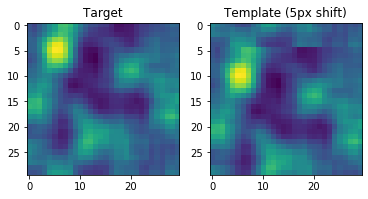

In [59]:
im1 = b2[1000:1030,500:530]
template = np.roll(target,5,axis=0)
kernel = np.ones((5,5),np.float32)/25
target = cv2.filter2D(im1,-1,kernel)

fig, ax = plt.subplots(1,2)
ax[0].imshow(target)
ax[0].set_title("Target")
ax[1].imshow(template)
ax[1].set_title("Template (5px shift)")
plt.show()


In [ ]:
lamb = np.linspace(-1,1.5,10)
mu = np.copy(0.1*lamb)
nitertab = np.zeros(10)
nitermax=3000
step0 = 0.01
for i in range(10):
    ux,uy,CF,step,nitertab[i]=RecalageDG(im1,im2,lamb[i],mu[i],nitermax,step0)

-1.0


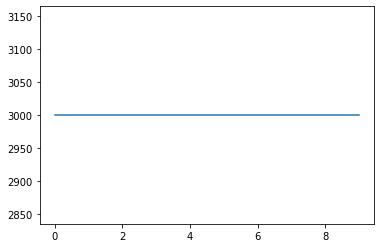

In [28]:
plt.plot(nitertab)
k = np.argmin(nitertab)
print(lamb[k])

In [28]:
k = 0.11
lamb0 = 0.11
mu = 0.1*lamb0
nitermax=3000
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(im1,im2,lamb0,mu,nitermax,step0)

iteration : 3  cost function : 80.51123776123845 step : 0.08
iteration : 6  cost function : 80.40180962749857 step : 0.64
iteration : 9  cost function : 79.84652172171097 step : 5.12
iteration : 12  cost function : 78.72598048711015 step : 2.56
iteration : 15  cost function : 78.5054947584329 step : 1.28
iteration : 18  cost function : 78.27150318449391 step : 1.28
iteration : 21  cost function : 78.02166236965697 step : 1.28
iteration : 24  cost function : 77.81155886669066 step : 1.28
iteration : 27  cost function : 77.58308728518236 step : 1.28
iteration : 30  cost function : 77.37504346993923 step : 2.56
iteration : 33  cost function : 77.15411612577407 step : 1.28
iteration : 36  cost function : 76.97135285700453 step : 1.28
iteration : 39  cost function : 76.79845605395136 step : 1.28
iteration : 42  cost function : 76.63732104953802 step : 1.28
iteration : 45  cost function : 76.47043259895965 step : 1.28
iteration : 48  cost function : 76.31136455181664 step : 1.28
iteration : 

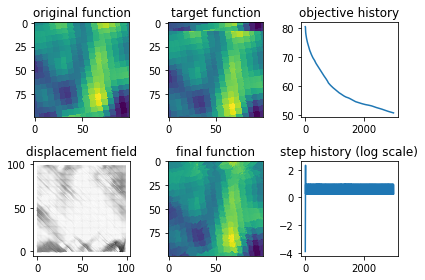

In [29]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im1)
ax[0,0].set_title('original function')
ax[0,1].imshow(im2)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im1,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

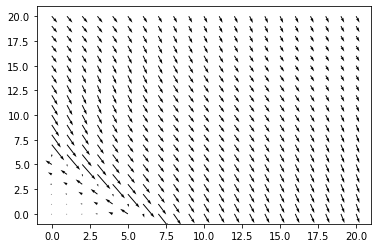

In [ ]:
plt.quiver(ux, uy)
plt.show()

In [ ]:
lambk = np.linspace(0,50,20)
muk = np.copy(lambk)
niter1 = np.zeros(20)
step1=0.01
eps1=0.1
nitermax=3000

for i in range(20) :
    ux,uy,CF,step,niter1[i]=RecalageGN(target,template,lambk[i],muk[i],nitermax,step1,eps1)

iteration : 3  cost function : 0.4466867074309917 step : 0.08
iteration : 6  cost function : 0.4458678740325265 step : 0.64
iteration : 9  cost function : 0.4393531604396029 step : 5.12
iteration : 12  cost function : 0.3900520875836228 step : 40.96
iteration : 15  cost function : 0.18575555111989675 step : 327.68
iteration : 18  cost function : 0.1229302335082229 step : 1310.72
iteration : 21  cost function : 0.06068982742489051 step : 655.36
iteration : 24  cost function : 0.041680416076619334 step : 327.68
iteration : 27  cost function : 0.03877595277964021 step : 163.84
iteration : 30  cost function : 0.038206795001747354 step : 40.96
iteration : 33  cost function : 0.03809986166698527 step : 327.68
iteration : 3  cost function : 0.4467624178965153 step : 0.08
iteration : 6  cost function : 0.4466642443951425 step : 0.64
iteration : 9  cost function : 0.4461474968844536 step : 5.12
iteration : 12  cost function : 0.44456859005539895 step : 2.56
iteration : 15  cost function : 0.443

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [24]:
epsi=0.1
nitermax=1000
lamb = 10.5
mu = lamb
step0=0.01
ux,uy,CF,step=RecalageGN(im1,im2,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 351.0509882895292 step : 0.08
iteration : 6  cost function : 349.83283546918807 step : 0.64
iteration : 9  cost function : 342.81823436203774 step : 5.12
iteration : 12  cost function : 327.03355473953496 step : 1.28
iteration : 15  cost function : 321.4833717428593 step : 2.56
iteration : 18  cost function : 317.43173575374425 step : 2.56
iteration : 21  cost function : 314.11884776353816 step : 2.56
iteration : 24  cost function : 311.3387616309926 step : 2.56
iteration : 27  cost function : 309.2553960803599 step : 1.28
iteration : 30  cost function : 306.80782665617244 step : 2.56
iteration : 33  cost function : 304.81399479488505 step : 2.56
iteration : 36  cost function : 303.1441175398639 step : 2.56
iteration : 39  cost function : 302.2245748562168 step : 1.28
iteration : 42  cost function : 300.4378992405051 step : 1.28
iteration : 45  cost function : 298.9775844837772 step : 2.56
iteration : 48  cost function : 297.7224796703974 step : 2.56
iter

ValueError: too many values to unpack (expected 4)

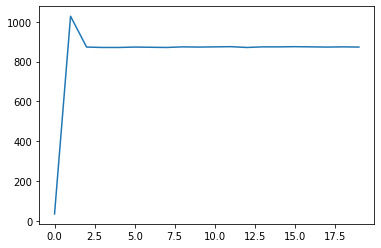

In [33]:
plt.plot(niter1)

In [34]:
k = np.argmin(niter1)
print(lambk[k])

0.0


In [35]:
lamb = lambk[k]
mu = lamb
epsi=0.1
nitermax= 3000
ux,uy,CF,step,n=RecalageGN(im2,im1,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 3.550829550396586 step : 0.08
iteration : 6  cost function : 3.515308509201881 step : 0.64
iteration : 9  cost function : 3.3175005862607145 step : 5.12
iteration : 12  cost function : 3.113172381809368 step : 40.96
iteration : 15  cost function : 2.7869343311277848 step : 327.68
iteration : 18  cost function : 2.3893406680031313 step : 2621.44
iteration : 21  cost function : 2.009249745276657 step : 10485.76
iteration : 24  cost function : 1.9781962400665993 step : 655.36
iteration : 27  cost function : 1.970208701083458 step : 5242.88
iteration : 30  cost function : 1.9645883197663263 step : 5242.88
iteration : 33  cost function : 1.9577136095368692 step : 655.36


on prend lambda = 10,5

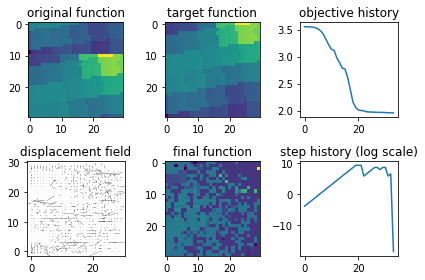

In [36]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im2)
ax[0,0].set_title('original function')
ax[0,1].imshow(im1)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im2,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

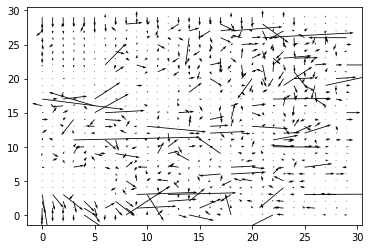

In [37]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

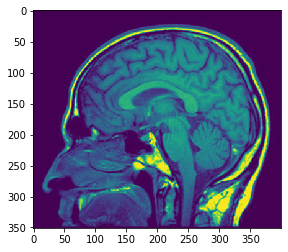

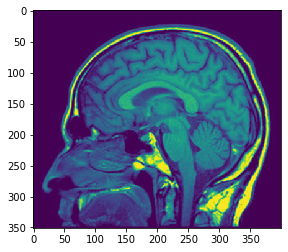

In [13]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [14]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [ ]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568826878 step : 0.08
iteration : 6  cost function : 0.1435182966307982 step : 0.64
iteration : 9  cost function : 0.1414353121976472 step : 5.12
iteration : 12  cost function : 0.12664688791055412 step : 40.96
iteration : 15  cost function : 0.07367524667918667 step : 327.68
iteration : 18  cost function : 0.054490660858069626 step : 20.48
iteration : 21  cost function : 0.053399614583654234 step : 20.48
iteration : 24  cost function : 0.053030424409352475 step : 10.24
iteration : 27  cost function : 0.05275613354759687 step : 10.24
iteration : 30  cost function : 0.05251414487138783 step : 10.24
iteration : 33  cost function : 0.05236623483392294 step : 10.24
iteration : 36  cost function : 0.05203014453222114 step : 10.24
iteration : 39  cost function : 0.05190443513327623 step : 5.12
iteration : 42  cost function : 0.051618297422295525 step : 5.12
iteration : 45  cost function : 0.05136707555049709 step : 10.24
iteration : 48  cost function 

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()